# julia implementation of convolutional network

## prepare data

In [27]:
function prepare_data()
    using HDF5
    # read data
    trn_fnm = "data/train.hdf5"
    tst_fnm = "data/test.hdf5"
    trn_d = h5read(trn_fnm, "/data")
    trn_l = h5read(trn_fnm, "/label")

    tst_d = h5read(tst_fnm, "/data")
    tst_l = h5read(tst_fnm, "/label")

    # reshape the data
    trn_d = reshape(trn_d, (784, 60000))
    trn_l = reshape(trn_l, 60000)
    tst_d = reshape(tst_d, (784, 10000))
    tst_l = reshape(tst_l, 10000)

    # create tuples of data and label
    # transform the label number to a vector matching network output
    trn = Array((Vector, Vector), 0)
    for k in 1:length( trn_l )
    #     println("k: $(k)")
        y = zeros(10)
        y[ trn_l[k]+1 ] = 1.0
        push!(trn, (trn_d[:,k], y))
    end

    tst = Array((Vector, Vector), 0)
    for k in 1:length(tst_l)
        y = zeros(10)
        y[ tst_l[k]+1 ] = 1.0
        push!(tst, (tst_d[:,k], y))
    end
    
    return (trn, tst)
end

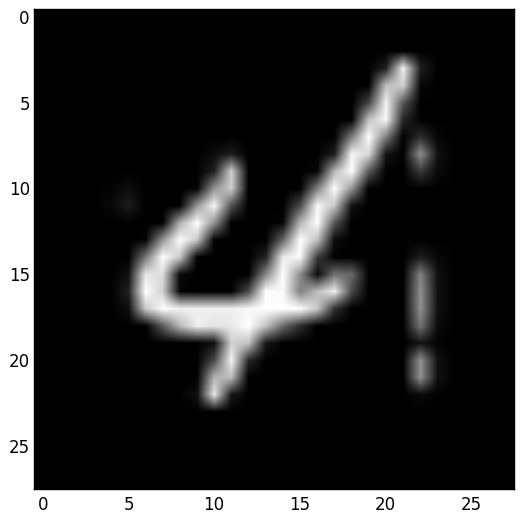

10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [30]:
using PyPlot

imshow(transpose(reshape(tst[1][1], (28,28))), cmap="gray")
tst[1][2]

In [31]:
type Network
    num_layers::Uint32
    sizes::Vector{Uint32}
    biases::Vector{Array}
    weights::Vector{Array}
    
    # inner construction function
    Network()=new(0,{},{},{})
    
    function Network(sizes::Vector)
        num_layers = length( sizes )
        biases = {[0]}
        weights = {[0]}
        for li in 2:num_layers
            push!(biases,  randn(sizes[li]) )
            push!(weights, randn(sizes[li], sizes[li-1]) ) 
        end
        new(num_layers, sizes, biases, weights)
    end
end

# return the vector of partial derivatives \partial C_x/ \partial a for the output activations
function cost_derivative(output_activations::Vector, y::Vector)
    return output_activations - y
end

# sigmoid function
function sigmoid( z )
    return 1.0./(1.0+exp(-z))
end

function sigmoid_prime(z)
    return sigmoid(z).*(1-sigmoid(z))
end

# define the functions of Network
function feedforward(net::Network, a::Array)
    # the input a is the first layer
    @fastmath @inbounds @simd for li in 2:net.num_layers
        a = sigmoid( w*net.weights[li] + net.biases[li] )
    end
    return a
end



# backpropagation
# Input : network 
# output: a tuple (nabla_b, nabla_w) representing the gradient for the cost function C_x.
function backprop(net::Network, x::Vector, y::Vector)
    
    # feedforward
    activation = x
    # list to store all the activations, layer by layer
    activations = {x}
    # list to store all the z vectors, layer by layer
    zs = {x}
    @fastmath @inbounds @simd for li in 2:net.num_layers
        z = net.weights[li]*activation + net.biases[li]
        push!(zs,z)
        activation = sigmoid(z)
        push!(activations, activation)
    end
    
    # backward pass
    nabla_b = {[0]}
    nabla_w = {[0]}
    for li in 2:net.num_layers
        push!(nabla_b, zeros(net.biases[li]))
        push!(nabla_w, zeros(net.weights[li]))
    end
    delta = cost_derivative(activations[end], y) .* sigmoid_prime(zs[end])
    nabla_b[end] = delta
    nabla_w[end] = delta * transpose(activations[end-1])
    @fastmath @inbounds @simd for li in net.num_layers-1:-1:2
#         println("new left: $(size(net.weights[li+1]))")
#         println("new right: $(size(delta))")
#         println("spv: $(size(spv))")
#         println("z: $(size(z))")
#         println("li: $(li)")
        delta = (transpose(net.weights[li+1]) * delta) .* sigmoid_prime(zs[li])
        nabla_b[li] = delta
        nabla_w[li] = delta * transpose(activations[li-1])
    end
    return (nabla_b, nabla_w)
end

# update the weights and biases by applying gradient descent using backpropagation to a single mini batch.
# mini_batch: a list of tuples "(x,y)"
# eta: the learning rate
function update_mini_batch!(net::Network, mini_batch::Array{(Vector, Vector)}, eta::Float32 )
    # initialization
    nabla_b = {[0]}
    nabla_w = {[0]}
    for li in 2:net.num_layers
        push!(nabla_b, zeros(net.biases[li]))
        push!(nabla_w, zeros(net.weights[li]))
    end
    for xy in mini_batch
        x,y = xy
        delta_nabla_b, delta_nabla_w = backprop(net, x, y)
        @fastmath @inbounds @simd for li in 2:net.num_layers
            nabla_b[li] = nabla_b[li] + delta_nabla_b[li]
            nabla_w[li] = nabla_w[li] + delta_nabla_w[li]
        end
    end
    # update the weights and biases using minibatch results
    @fastmath @inbounds @simd for li in 2:net.num_layers
        net.biases[li]  = net.biases[li]  - eta*(nabla_b[li]./length(mini_batch))
        net.weights[li] = net.weights[li] - eta*(nabla_w[li]./length(mini_batch))
    end
end

# evaluate the results
function evaluate(net::Network, tst)
    # correct number
    cn = 0
    for xy in tst
        x,y = xy
        yt = feedforward(net, x)
        if indmax(yt)==indmax(y)
            cn = cn + 1
        end
    end
    return cn./length(tst)
end

# 
function SGD( net::Network, trn::Vector{(Vector, Vector)}, epoches::Uint32, 
    mini_batch_size::Uint32, eta::Float32, tst::Vector{(Vector, Vector)} )
    println("starting stochastic gradient descent training...")
    # number of samples
    n_tst = length( tst )
    n_trn = length( trn )
    
    for j in 1:epoches
        print("Epoch $(j)...")
        # shuffle the training data
        shuffle!(trn)
        # minibatch
        for k in 1:mini_batch_size:n_trn
#             if k%1000 == 1
#                 cls = evaluate(net, tst)
#                 println("k: $(k), cls: $(cls)")
#             end
            mini_batch = trn[k:k+mini_batch_size-1]
            update_mini_batch!(net, mini_batch, eta)
        end
        
        # test
        cls = evaluate(net, tst)
        println("cls: $(cls)")
    end
end

SGD (generic function with 1 method)

In [ ]:
trn, tst = prepare_data()
const sizes = [784, 30, 10]
net::Network = Network( sizes )
SGD(net::Network, trn, uint32(30), uint32(10), float32(3.0), tst)

starting stochastic gradient descent training...


In [12]:
evaluate(net, tst)

0.1003